# Tests

In [21]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
import ptsymmetric
import dimod
import matplotlib.pyplot as plt
import json
import os
import minorminer
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict

In [9]:
def create_instance(precision, number_time_points,instance_id = 1,  simplify = True):
    if instance_id == 1:
        SY = np.array([[0, -1.0j], [1.0j, 0.0]])
        PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.
        H = 0.5 * np.pi * SY
    if instance_id == 2:
        PSI0 = ptsymmetric.bell_state(state='00').full()
        H = ptsymmetric.generate_pt_symmetric_hamiltonian(2).full()

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(number_time_points)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    # for some reason multiple iterations over the qubo are necessary
    # to remove all 0 couplers
    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2

    # save instances in the form 
    # systemid_{d}_precision_{d}_timepoints_{d}.json
    # systemid: {1: 0.5 * np.pi * SY}
    file_name = f"../data/instances/pruned/{instance_id}/precision_{precision}_timepoints_{number_time_points}.json"
    with open(file_name,'w') as f:
        json.dump(qubo.to_serializable(),f)
    return qubo


In [10]:
for precision in range(2,5):
    for timespoints in range(3,6):
        create_instance(precision=precision,number_time_points=timespoints, instance_id=2)

In [11]:
def get_sampleset(precision,timepoints,solver_id="5.4",instance_id = 1, simplify = True):
    qubo = create_instance(precision, timepoints, instance_id, simplify)

    # The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
    dw_sampler = ""
    if solver_id == "5.4":
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage_system5.4", region="eu-central-1", ))
    elif solver_id == "2.6": # zephyr
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage2_prototype2.6"))
    elif solver_id == "6.4": 
        dw_sampler = EmbeddingComposite(DWaveSampler(solver="Advantage_system6.4"))


    dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

    return dw_result



In [ ]:
system = 2
prune = True
for solver in ["5.4"]:
    print(f"Solver {solver}")
    for i in range(1,3): # number of tests
        print(f"Iteration {i}")
        for timepoints in [3,4,5]:
            for precision in [2,3,4]:
                dw_result = get_sampleset(solver_id=solver, precision=precision,timepoints=timepoints,instance_id=system, simplify=prune)
                if prune:
                    file_name = f"../data/results/pruned/{system}/{solver}/precision_{precision}_timepoints_{timepoints}_{i}.json"
                else:
                    file_name = f"../data/results/notpruned/{system}/{solver}/precision_{precision}_timepoints_{timepoints}_{i}.json"

                with open(file_name,'w') as f:
                    json.dump(dw_result.to_serializable(),f)

Solver 5.4
Iteration 1


# Analyze

In [14]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


In [15]:
topology = '5.4'
system = 2
def load_data(pruned = True, raw = False,topology='5.4'):
    if pruned:
        path = f'../data/results/pruned/{system}/'

    else:
        path = f'../data/results/notpruned/{system}/'
    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            s = s.to_pandas_dataframe()

            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [16]:
dfs_all = load_data(pruned = True,topology=topology)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram

In [17]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum()
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum()

dfs_grouped_rounded 

/tmp/ipykernel_14778/254841501.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 

systemid  precision  timepoints  energy
5.4       2          3           32        0.001
                                 34        0.001
                                 45        0.001
                                 47        0.001
                                 48        0.001
                                           ...  
          4          4           310       0.001
                                 314       0.001
                                 316       0.001
                                 318       0.001
                                 334       0.001
Name: num_occurrences, Length: 2552, dtype: float64

defaultdict(<class 'list'>, {4: [4, 2, 3], 3: [4, 2, 3], 5: [2, 3]})
prec 2 timepoints 3
     energy  num_occurrences
0        32            0.001
1        34            0.001
2        45            0.001
3        47            0.001
4        48            0.001
..      ...              ...
173     234            0.001
174     235            0.001
175     251            0.001
176     266            0.001
177     273            0.001

[178 rows x 2 columns]
prec 3 timepoints 3
     energy  num_occurrences
0        45            0.002
1        47            0.001
2        49            0.001
3        51            0.001
4        52            0.002
..      ...              ...
155     233            0.001
156     239            0.001
157     240            0.002
158     242            0.001
159     250            0.001

[160 rows x 2 columns]
prec 4 timepoints 3
     energy  num_occurrences
0        37            0.001
1        38            0.002
2        43            0.003
3        44

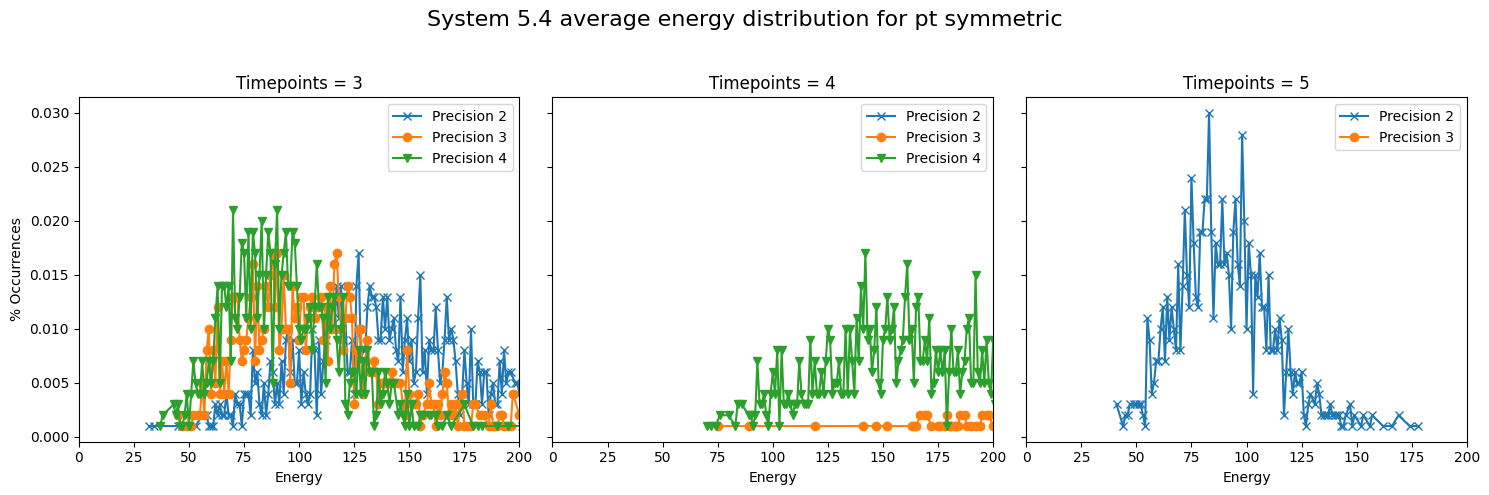

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"System {topology} average energy distribution for pt symmetric", fontsize=16)
markers = ['x','o','v']
prec_time_pairs = get_precision_timepoints_pairs(dfs_all)
timepoint_dict = defaultdict(list)
for timepoint_par in prec_time_pairs:
    timepoint_dict[timepoint_par[1]].append(timepoint_par[0])

print(timepoint_dict)
timepoints = sorted(timepoint_dict.keys())
for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    for p in sorted(timepoint_dict[timepoint]):
        df = dfs_grouped_rounded[topology, p, timepoint].reset_index()
        print(f"prec {p} timepoints {timepoint}")
        print(df)
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoint}")
    ax.set_xlim(0, 200)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

In [24]:
# Let's compute baseline using QuTiP
import qutip as qp

H_qp = 0.5 * np.pi * qp.sigmay()

psi_0 = qp.basis(2, 0)
times = np.linspace(0, 3, 100)
baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

# Simplification ?

In [61]:
dfs_not_pruned = load_data(pruned=False,precision_range=(2,3))
dfs_not_pruned

,energy,num_occurrences,systemid,precision,timepoints
0,1.0,1,5.4,2,3
1,1.0,1,5.4,2,3
2,1.0,1,5.4,2,3
3,2.0,1,5.4,2,3
4,2.0,1,5.4,2,3
...,...,...,...,...,...
995,20.0,1,5.4,2,5
996,29.0,1,5.4,2,5
997,22.0,1,5.4,2,5
998,52.0,1,5.4,2,5


In [64]:
dfs_not_pruned['energy'] = round(dfs_not_pruned['energy'] +0.499) # for displaying in a histogram
dfs_not_pruned = dfs_not_pruned.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_not_pruned

systemid  precision  timepoints  energy
5.4       2          3           0.0         2
                                 1.0        26
                                 2.0        86
                                 3.0       221
                                 4.0       344
                                          ... 
                     5           54.0        4
                                 57.0        1
                                 58.0        1
                                 60.0        1
                                 64.0        1
Name: num_occurrences, Length: 136, dtype: int64

(0.0, 10.0)

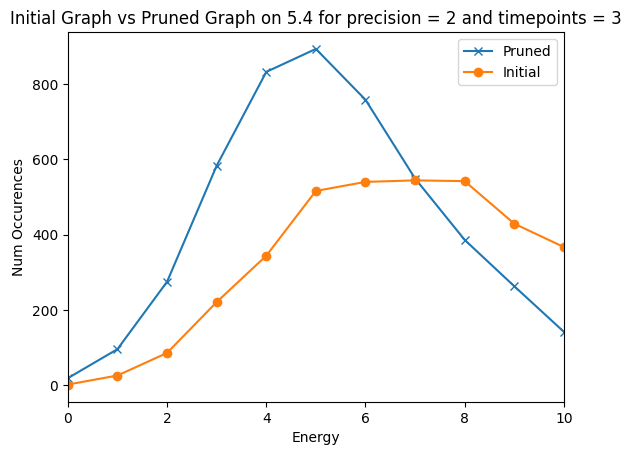

In [75]:
#plt.plot(dfs_not_pruned['energy'],dfs_not_pruned['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['5.4',2,3],label="Pruned",marker='x')
plt.plot(dfs_not_pruned['5.4',2,3],label="Initial",marker='o')

plt.xlabel('Energy')
plt.title("Initial Graph vs Pruned Graph on 5.4 for precision = 2 and timepoints = 3")
plt.ylabel('Num Occurences')
plt.legend()

plt.xlim(0,10)

-more qubits
-pt symmetric eq 12 paper
- include specific machine

# Interpret results

In [53]:
dfs_data_raw = load_data(raw=True,topology=topology)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']

0      6.4
1      6.4
2      6.4
3      6.4
4      6.4
      ... 
995    6.4
996    6.4
997    6.4
998    6.4
999    6.4
Name: systemid, Length: 44613, dtype: object

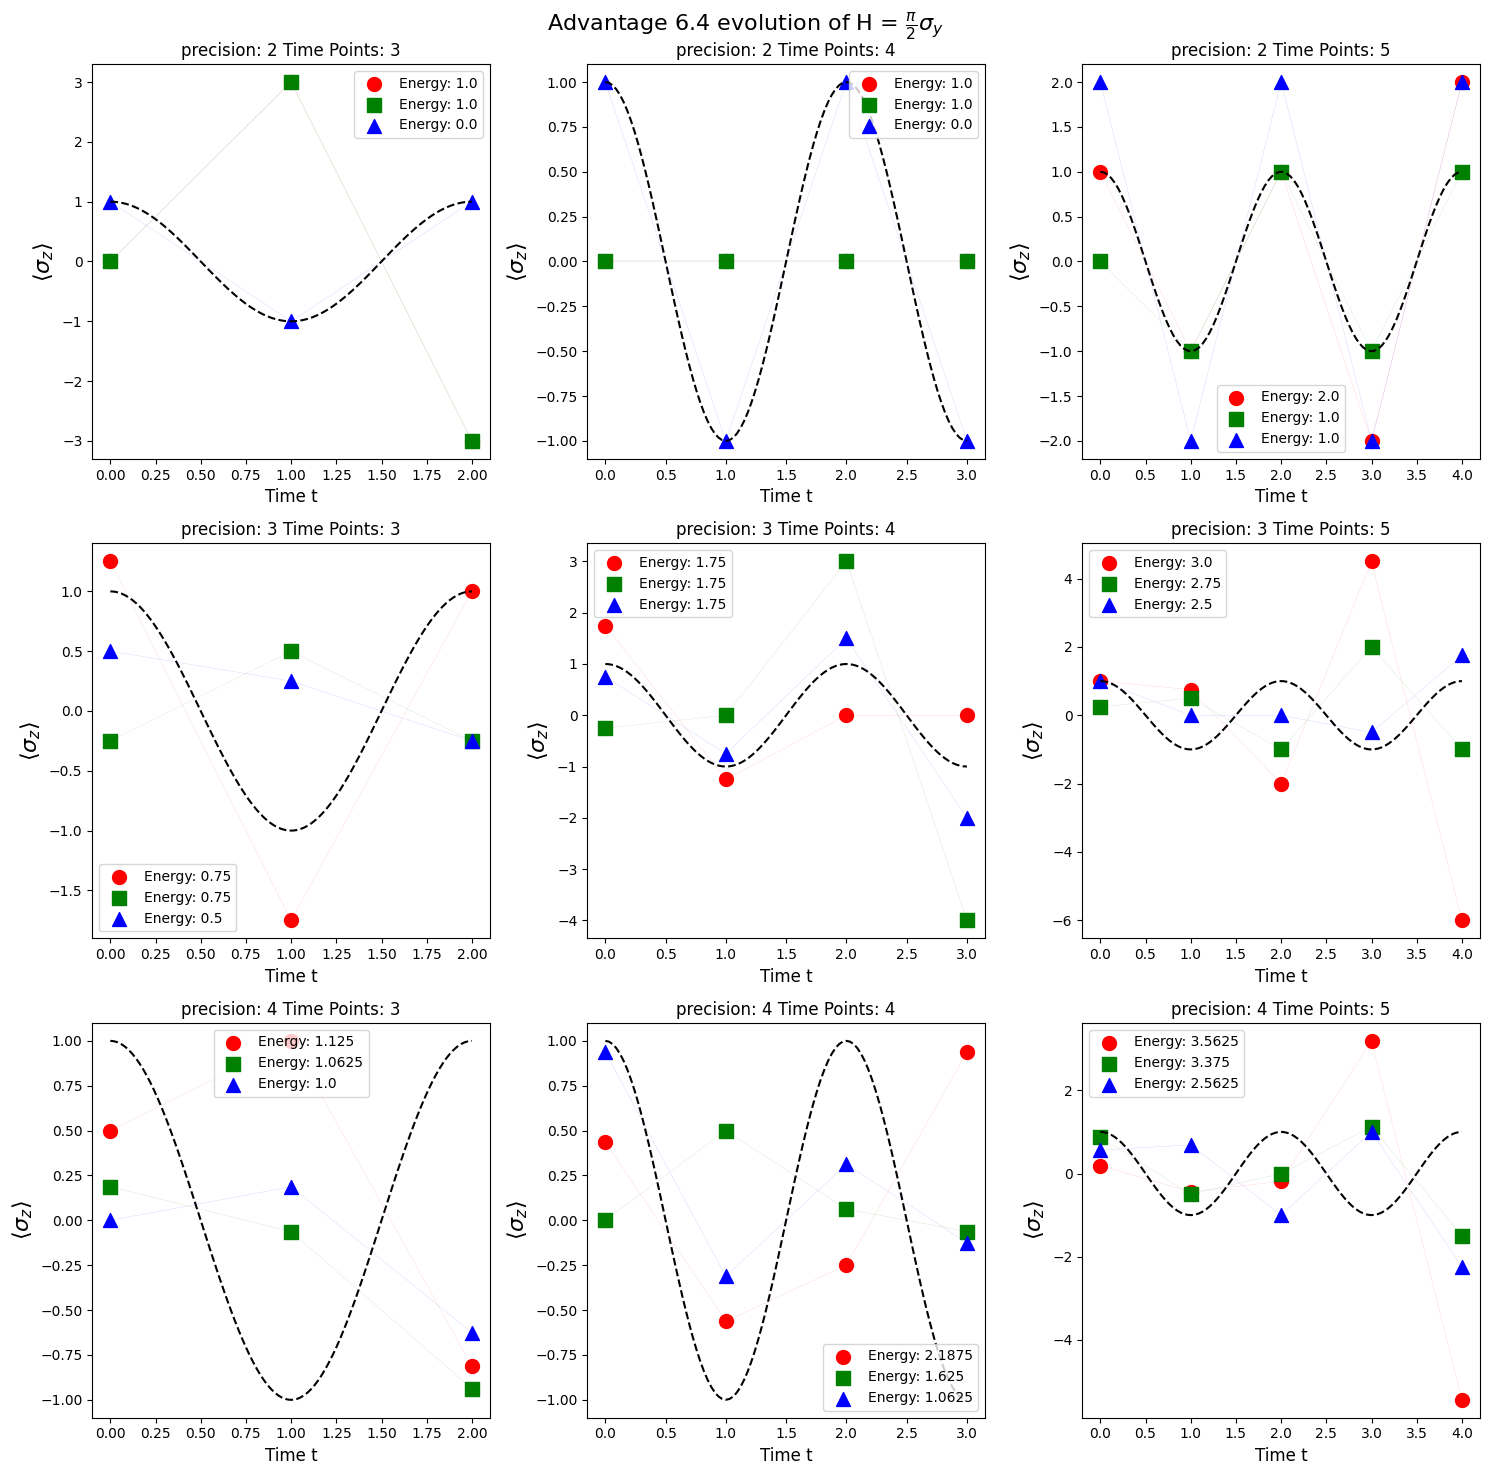

In [54]:
import qutip as qp

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

for i, (precision,timepoints) in enumerate(tp_pairs):
    #baseline 

    H_qp = 0.5 * np.pi * qp.sigmay()
    psi_0 = qp.basis(2, 0)
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

    ax = axes[i]

    ax.plot(times, baseline, "k--")

    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)
        SZ = np.array([[1, 0], [0, -1]])

        expect = [(state.conj() @ SZ @ state).real for state in vec]
        ax.scatter(problem.times, expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"Energy: {energies[j]}", alpha=1.0, s=100)
        ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +r"evolution of H = $\frac{\pi}{2}\sigma_y$",fontsize=16)
plt.tight_layout()
plt.savefig(f'../plots/system{topology}_dynamic_1.pdf')
plt.show()



In [34]:
sol_dict = dfs_data_raw.iloc[0,:].dropna().to_dict()
sol_dict = {key:int(value) for key,value in sol_dict.items()}

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

prec = 2
timepoints = 4
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(timepoints)),             # With six time points 0,1,2
    num_bits_per_var=prec               # And two bits of precision per variable
)
print(sol_dict)
vec =problem.interpret_sample(sol_dict)

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 1}


In [ ]:
SZ = np.array([[1, 0], [0, -1]])

expect = [(state.conj() @ SZ @ state).real for state in vec]

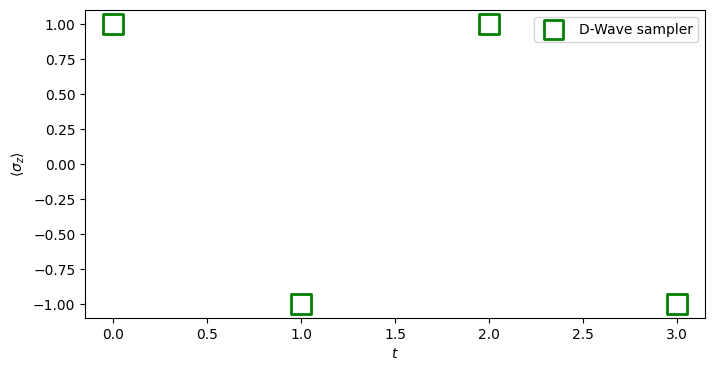

In [36]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

#axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

#axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
#axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()